# Deep Q-Network (DQN)


In [76]:
import gym
import random
import torch
import numpy as np


from collections import namedtuple, deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline


In [87]:
env = gym.make('LunarLander-v2') # select which game we want to run
#env = gym.make('CartPole-v0')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

BUFFER_SIZE = 10000   # replay buffer size
BATCH_SIZE = 64         # batch size
GAMMA = 0.99            # discount factor
TAU = 0.001              # for soft update of target parameters
LR = 0.005               # learning rate 
UPDATE_EVERY = 4 # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


('State shape: ', (8,))
('Number of actions: ', 4)


In [88]:
GAMMAS = [0.9, 0.95, 0.99]
TAUS = [1e-3, 1e-2, 1e-1]
UPDATE_EVERYS = [4, 6, 8]

In [89]:

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=16):
    
        #    fc1 = Number of nodes in first hidden layer
        #    fc2 = Number of nodes in second hidden layer
    
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        # network that maps state -> action values.
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Agent():
    def __init__(self, state_size, action_size, seed, gamma, tau, update_every):
  
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.update_every = update_every
        self.tau = tau
        self.gamma = gamma

        # Q-Network
        self.x = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps):
        #Returns actions for given state as per current policy.
        #  state (array_like): current state
        #    eps (float): epsilon, for epsilon-greedy action selection
        #
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        eps =0
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
    #Update value parameters using given set of experience tuples.
    #       experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
    #      gamma: discount factor
        states, actions, rewards, next_states, done = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - done))  # Compute Q  for current states 
        Q_expected = self.qnetwork_local(states).gather(1, actions)   # Get expected Q values from local model

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.interpolate(self.qnetwork_local, self.qnetwork_target, self.tau)                     

    def interpolate(self, local_model, target_model, tau):

        #  local_model  weights will be copied from
        # target_model  weights will be copied to
        #  tau : interpolation parameter
        #θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)        
    
    def add(self, state, action, reward, next_state, done):
        #Add a new experience to memory
        self.memory.append(self.experience(state, action, reward, next_state, done))
    
    def sample(self):
        #sample a batch of experiences from  replay memor
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        done = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, done)


In [90]:
# use the first agent if sweeping parameters on lunar lander
# the second if you are using the cartpole
# 3rd if you are using the lunar lifter without sweeping
#agent = Agent(8, 4, 0, params['gamma'], params['tau'], params['update_every'])
#agent = Agent(4, 2, 0, 0.99, 0.01, 4)
agent = Agent(8, 4, 0, 0.99, 0.01, 4)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state,0)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

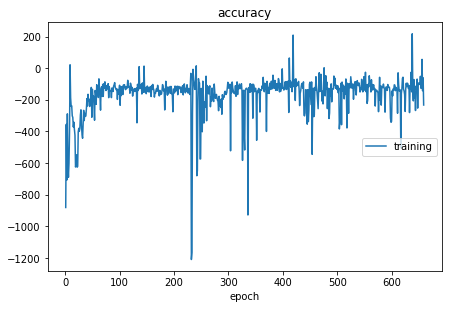

accuracy:
training   (min: -1210.804, max:  217.717, cur: -233.131)
Episode 659	Average Score: -139.95


KeyboardInterrupt: 

In [85]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
      #  n_episodes (int): maximum number of training episodes
      #  max_t (int): maximum number of timesteps per episode
      #  eps_start (float): starting value of epsilon, for epsilon-greedy action selection
      #  eps_end (float): minimum value of epsilon
      #  eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    scores = []                        # list of scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # init epsilon
    liveloss = PlotLosses()
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
                
        liveloss.update({
            'accuracy': score
        })
        liveloss.draw()        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\ solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# setup sweeping params
def generate_params():
    for gamma in GAMMAS:
        for tau in TAUS:
            for update_every in UPDATE_EVERYS:
                param = dict()
                param['gamma'] = gamma
                param['tau'] = tau
                param['update_every'] = update_every
                yield param

In [173]:
scan_params = list(generate_params())

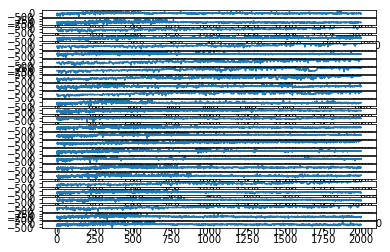

In [174]:
import glob
import pickle
fnames = glob.glob('probe*')


for index, fname in enumerate(fnames):
    with open(fname, 'r') as f:
        a = pickle.load(f)
    plt.subplot(len(fnames), 1, index + 1)
    plt.plot(a)
plt.show()
    
    

In [179]:

## same as above only now we are sweeping hyper parameters 

def scan_dqn(params, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):


   #     eps_start starting value of epsilon, for epsilon-greedy action selection
   #     eps_end end value of epsilon
   #     n_episode: maximum number of training episodes
   #     max_t = maximum number of timesteps per episod
    print(params)
    agent = Agent(8, 4, 0, params['gamma'], params['tau'], params['update_every'])
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    liveloss = PlotLosses()
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
                
        liveloss.update({
            'accuracy': score
        })
        liveloss.draw()        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 
                'checkpoint_{}_{}_{}.pth'.format(params['gamma'], params['tau'], params['update_every']))
            break
    import pickle
    with open('probe_{}_{}_{}.pth'.format(params['gamma'], params['tau'], params['update_every']), 'wb') as f:
        pickle.dump(scores, f)
    return scores


KeyboardInterrupt: 

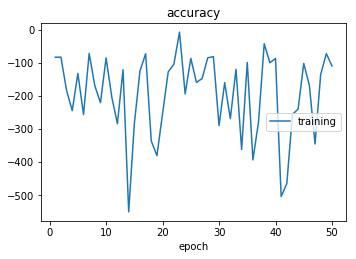

In [180]:
res = [scan_dqn(p) for p in scan_params]

In [ ]:
# THIS is one of the be results we got below we saved our weights 
#so you can see the results

In [92]:
# loading the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_0.99_0.001_4.pth'))

for i in range(5):
    state = env.reset()
    for j in range(1000):
        action = agent.act(state,0)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

In [ ]:
# everything else below is for data processing and visualizing

In [8]:
import glob
import pickle
from scipy.signal import hilbert
fnames = glob.glob('probe*')
import re
from scipy.signal import butter, lfilter, freqz



In [9]:
fnames


['probe_0.95_0.1_4.pth',
 'probe_0.9_0.001_6.pth',
 'probe_0.99_0.001_6.pth',
 'probe_0.95_0.001_8.pth',
 'probe_0.99_0.1_8.pth',
 'probe_0.9_0.1_6.pth',
 'probe_0.99_0.001_4.pth',
 'probe_0.99_0.1_4.pth',
 'probe_0.99_0.01_6.pth',
 'probe_0.95_0.001_6.pth',
 'probe_0.99_0.01_4.pth',
 'probe_0.95_0.01_4.pth',
 'probe_0.9_0.001_8.pth',
 'probe_0.9_0.1_4.pth',
 'probe_0.9_0.01_6.pth',
 'probe_0.95_0.1_8.pth',
 'probe_0.99_0.001_8.pth',
 'probe_0.95_0.001_4.pth',
 'probe_0.95_0.01_6.pth',
 'probe_0.95_0.01_8.pth',
 'probe_0.95_0.1_6.pth',
 'probe_0.99_0.1_6.pth',
 'probe_0.9_0.01_8.pth',
 'probe_0.9_0.1_8.pth',
 'probe_0.99_0.01_8.pth',
 'probe_0.9_0.001_4.pth',
 'probe_0.9_0.01_4.pth']

In [104]:
lst = []
dataset = []
for fn in fnames:
    gamma, tau, f = fn.replace('.pth', "").split('_')[1:4]
    lst.append((float(gamma), float(tau), float(f)))
    with open(fn, 'r') as f:
        data = pickle.load(f)
        dataset.append(data)




def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [112]:
import pandas as pd
nplst = np.asarray(lst)
df = pd.DataFrame({'gamma': nplst[:,0], 'tau': nplst[:,1], 'filter': nplst[:,2], 'data': dataset})







In [1]:
#df['total'] = df.loc[df['gamma'] ==0.99,['data']].sum(axis=0

In [115]:
dftemp2 = df[(df['filter'] == 4.0) & (df['gamma'] ==0.99)]
#dftemp['total'] = dftemp.sum(axis=0)
dftemp2

,data,filter,gamma,tau
6,"[-124.85905987161726, -198.71619476201383, -91...",4.0,0.99,0.001
7,"[-101.86965434188768, -80.62898736707983, -92....",4.0,0.99,0.100
10,"[-38.55639654311881, -182.3655236858653, -250....",4.0,0.99,0.010


In [100]:

calcmin = []
for index, row in dftemp.iterrows():
    print(len(row['data']))
    calcmin.append(len(row['data']))
calcmin = min(calcmin)
#     tempdata= np.vstack([tempdata,(row['data'])])
# tempdata = np.asarray(tempdata)
# print(tempdata)
#tempdata = np.mean(tempdata, axis=0)
#print(tempdata)


661
661
661


In [78]:
print(len(row['data']))
for index, row in dftemp.iterrows():
    del (row['data'])[calcmin:]


2000


(3,)
3


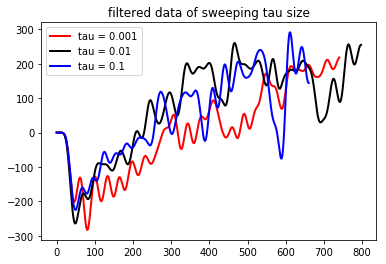

In [118]:
    
tempdata = []

for index, row in dftemp2.iterrows():
     tempdata.append(row['data'])
tempdata = np.asarray(tempdata)
print(tempdata.shape)
#mean = np.mean(tempdata,axis=0)
#print(len(mean))
#plt.figure()
#plt.title("tau = 0.1")
#plt.plot(mean)


print(len(tempdata))
y = []
for data in tempdata:
        order = 10
        fs = 30      # sample rate, Hz
        cutoff = 1  # desired cutoff frequency of the filter, Hz
        # Get the filter coefficients so we can check its frequency response.
        b, a = butter_lowpass(cutoff, fs, order)

        # Plot the frequency response.

        y.append(butter_lowpass_filter(data, cutoff, fs, order))
        
plt.figure()
plt.title("filtered data of sweeping tau size")
plt.plot(y[0], color = 'red', label='tau = 0.001', linewidth=2)
plt.plot(y[2], color='k', label='tau = 0.01', linewidth=2)
plt.plot(y[1], color = 'blue', label='tau = 0.1', linewidth=2)
plt.legend()

plt.show()

probe_0.99_0.01_8.pth
0.99_0.01


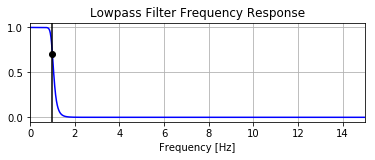

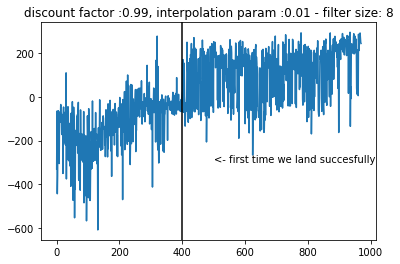

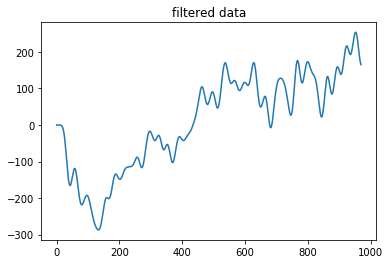

In [49]:
order = 2
fs = 2      # sample rate, Hz
cutoff = 100  # desired cutoff frequency of the filter, Hz

for index, fname in enumerate(fnames):
    
    with open(fname, 'r') as f:
        data = pickle.load(f)
    if index == 24:
        print(fname)
        plt.subplot(111) #len(fnames), 1, index + 1)
        x = np.linspace(0,2000,2000,endpoint = True)
        plt.plot(data)
        result = re.search('_(.*)_', fname)
        plt.title("discount factor :0.99, interpolation param :0.01 - filter size: 8")
        plt.axvline(x=400,color='k')
        plt.text(500,-300,'<- first time we land succesfully')
        plt.show
        plt.figure(0)
        order = 10
        fs = 30      # sample rate, Hz
        cutoff = 1  # desired cutoff frequency of the filter, Hz

        # Get the filter coefficients so we can check its frequency response.
        b, a = butter_lowpass(cutoff, fs, order)

        # Plot the frequency response.
        w, h = freqz(b, a, worN=8000)
        plt.subplot(2, 1, 1)
        plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
        plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
        plt.axvline(cutoff, color='k')
        plt.xlim(0, 0.5*fs)
        plt.title("Lowpass Filter Frequency Response")
        plt.xlabel('Frequency [Hz]')
        plt.grid()
        print result.group(1)
        y = butter_lowpass_filter(data, cutoff, fs, order)
        plt.figure()
        plt.title("filtered data")
        plt.plot(y)
        
        

In [29]:
len(y)

798